## Bead-Spring Polymer VAE

This polymer has each bead (atom) joined by a harmonic bond, a harmonic angle between each three, and a Lennard-Jones interaction potential. Knowing these items will not be necessary for the example. Each of our data points below will be the x and y coordinates of 12 beads. We'll construct a VAE that can compress the trajectory to some latent space and generate new conformations.

Since we're now work with continuous features $x$. We need to make a few key changes. The encoder will remain the same, but the decoder now must output a $p_\theta(x | z)$ that gives a probability to all possible $x$ values. Above, we only had a finite number of classes but now any $x$ is possible. The $p_\theta(x | z)$ should be normal and should be modeled as as a Gaussian and output the parameters (mean and possibly variance). The reconstruction loss would then be the negative log-likelihood under that Gaussian. Here, for simplicity, we instead use mean squared error (MSE) between the predicted and true coordinates. This is equivalent to assuming a Gaussian likelihood with fixed variance and ignoring constant terms in the loss.

To begin, we'll need to align points from a trajectory in order to ensure the data is translationally and rotationally invariant. This will then serve as our training data. The space of our problem will be 12 2D vectors. Our system need not be permutation invariant, so we can flatten these vectors into a 24 dimensional input. The code belows loads and aligns the trajectory


In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import urllib
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn, torch.nn.functional as F
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

The dataset consists of a molecular dynamics trajectory of a simple 12-bead polymer chain in 2D space. Each frame in the trajectory represents one conformation of the polymer and contains the x and y coordinates of all 12 beads.

Each data point has the shape: [12 beads, 2 coordinates]

The data array is [N, 12 beads, 2 coordinates]

In [2]:
# import data
url = "https://github.com/whitead/dmol-book/raw/main/data/long_paths.npz"
urllib.request.urlretrieve(url, "paths.npz")
xyz = np.load("paths.npz")["arr"]          # (Nframes, Natoms, 2)

In [3]:
###---------Transformation Functions----###
# for rotational/translational invariance

# helper: centring + PCA alignment (identical to dmol.pub helpers)
def center_com(x):                         # centre each frame at COM
    return x - x.mean(1, keepdims=True)

def align_principle(x):                    # align principal axis per frame
    R = []
    for frame in x:
        u, _, _ = np.linalg.svd(frame.T @ frame)
        R.append(frame @ u)                # rotate
    return np.stack(R)

data = align_principle(center_com(xyz))    # (N, A, 2)

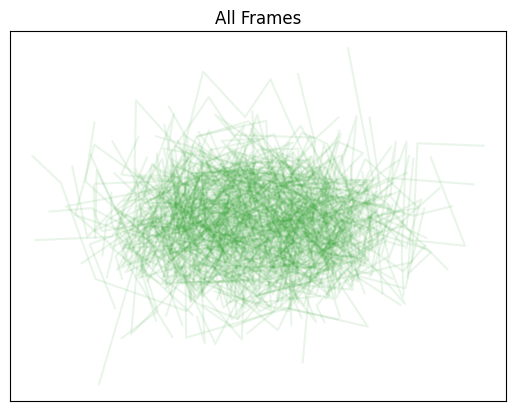

In [4]:
# visualize all the data
cmap = plt.get_cmap("cool")
for i in range(0, data.shape[0], 16):
    plt.plot(data[i, :, 0], data[i, :, 1], "-", alpha=0.1, color="C2")
plt.title("All Frames")
plt.xticks([])
plt.yticks([])
plt.show()

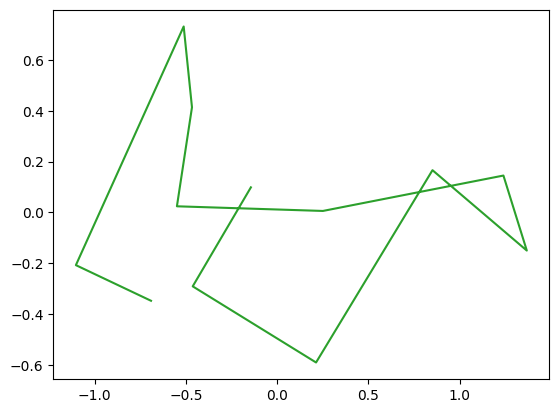

In [5]:
# visualize a single data point
plt.plot(data[3, :, 0], data[3, :, 1], "-", color="C2")

Before training, let’s examine some of the marginals of the data to visualize the data. Marginals mean we’ve transformed (by integration) our probability distribution to be a function of only 1-2 variables so that we can plot nicely. We’ll look at the pairwise distance between beads (beads are indexed 0-11).

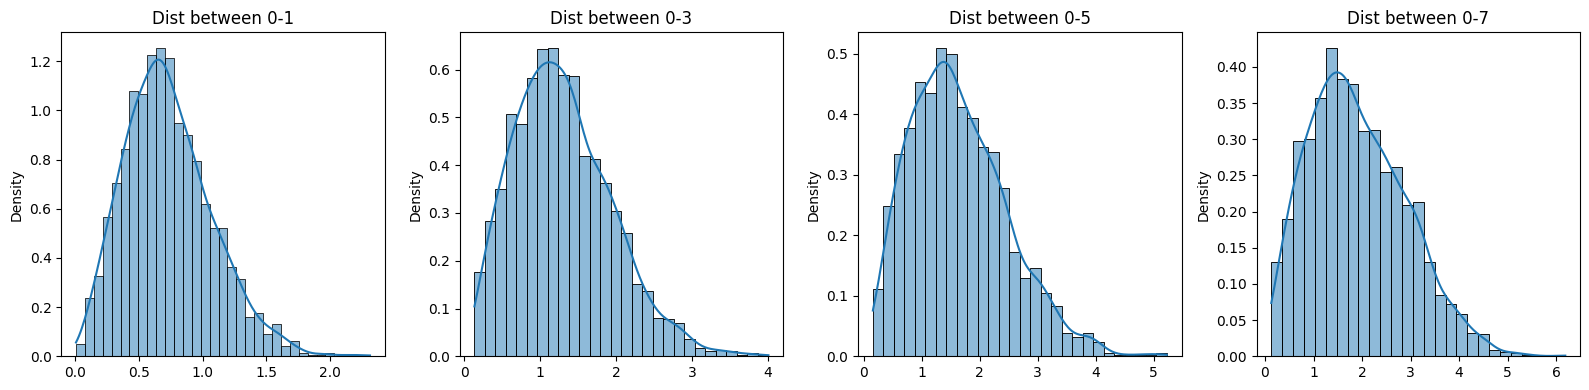

In [6]:
fig, axs = plt.subplots(ncols=4, squeeze=True, figsize=(16, 4))
for i, j in enumerate(range(1, 9, 2)):
    axs[i].set_title(f"Dist between 0-{j}")
    sns.histplot(np.linalg.norm(data[:, 0] - data[:, j], axis=1), ax=axs[i], kde=True, stat="density")
plt.tight_layout()

In [7]:
# prepare the input

X = data.reshape(len(data), -1).astype("float32")
input_dim = X.shape[1]

tensorX = torch.tensor(X).to(device)
loader  = DataLoader(TensorDataset(tensorX), batch_size=256, shuffle=True)

### VAE Model

Now we'll build the VAE similar to before.

In [123]:
# Dimensions (flattened 12 × 2 bead positions)
input_dim   = 24
latent_dim  = 2
hidden_dim  = 32

# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # outputs μ and σ̂
        )

    def forward(self, x):
        out = self.net(x)
        mu, log_sig = out[:, :latent_dim], out[:, latent_dim:]
        sigma = F.softplus(log_sig)
        return mu, sigma

# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)  # outputs mean of p(x|z)
        )

    def forward(self, z):
        return self.net(z)


### Loss

The loss function is similar to above, but I will not bother sampling from the decoded distribution, and instead just take the value outputted from the decoder. You can see the only change is that we drop the output Gaussian standard deviation from the loss, which remember was not trainable anyway.

In [124]:
# Instantiate models
encoder = Encoder().to(device)
decoder = Decoder().to(device)
opt     = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-2)

# VAE loss (MSE-based reconstruction)
def vae_loss(x, beta=1.0):
    mu, sigma = encoder(x)
    eps = torch.randn_like(mu)
    z = mu + sigma * eps

    x_hat = decoder(z)

    # Reconstruction loss: mean squared error
    recon = F.mse_loss(x_hat, x, reduction="none").sum(dim=1)

    # KL divergence: between q(z|x) ~ N(μ,σ²) and p(z) ~ N(0,1)
    kl = -torch.log(sigma) + 0.5 * (sigma**2 + mu**2) - 0.5
    kl = kl.sum(dim=1)

    return (recon + beta * kl).mean(), recon.mean(), kl.mean()


In [125]:
# Training loop
epochs = 40
loss_traj, recon_traj, kl_traj = [], [], []

for epoch in range(epochs):
    for batch in loader:
        x = batch[0]  # extract batch input from TensorDataset

        opt.zero_grad()

        loss, recon, kl = vae_loss(x, beta=0.01)
        loss.backward()
        opt.step()

        # Store loss values
        loss_traj.append(loss.item())
        recon_traj.append(recon.item())
        kl_traj.append(kl.item())

    print(f"Epoch {epoch+1}/{epochs} — Loss: {loss.item():.4f}, Recon: {recon.item():.4f}, KL: {kl.item():.4f}")

Epoch 1/40 — Loss: 13.4157, Recon: 13.4001, KL: 1.5580
Epoch 2/40 — Loss: 7.8596, Recon: 7.7616, KL: 9.8039
Epoch 3/40 — Loss: 6.8390, Recon: 6.7365, KL: 10.2575
Epoch 4/40 — Loss: 6.5537, Recon: 6.4487, KL: 10.4913
Epoch 5/40 — Loss: 6.6272, Recon: 6.5261, KL: 10.1158
Epoch 6/40 — Loss: 6.6002, Recon: 6.5067, KL: 9.3511
Epoch 7/40 — Loss: 6.0836, Recon: 5.9869, KL: 9.6760
Epoch 8/40 — Loss: 6.1089, Recon: 6.0127, KL: 9.6277
Epoch 9/40 — Loss: 5.7138, Recon: 5.6246, KL: 8.9219
Epoch 10/40 — Loss: 5.2419, Recon: 5.1477, KL: 9.4208
Epoch 11/40 — Loss: 4.9685, Recon: 4.8728, KL: 9.5676
Epoch 12/40 — Loss: 4.7701, Recon: 4.6760, KL: 9.4121
Epoch 13/40 — Loss: 4.7201, Recon: 4.6299, KL: 9.0251
Epoch 14/40 — Loss: 4.7645, Recon: 4.6792, KL: 8.5297
Epoch 15/40 — Loss: 4.7177, Recon: 4.6344, KL: 8.3291
Epoch 16/40 — Loss: 4.8410, Recon: 4.7586, KL: 8.2369
Epoch 17/40 — Loss: 4.7092, Recon: 4.6207, KL: 8.8517
Epoch 18/40 — Loss: 4.8626, Recon: 4.7757, KL: 8.6985
Epoch 19/40 — Loss: 4.6088, Reco

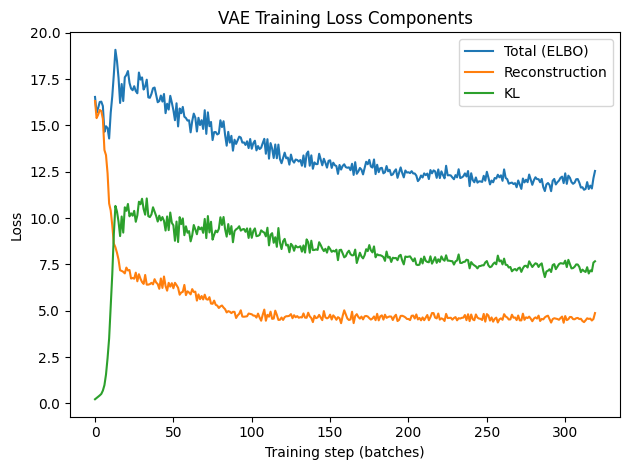

In [126]:
# Convert to numpy arrays
elbo = np.array(recon_traj) + np.array(kl_traj)

plt.plot(elbo, label="Total (ELBO)")
plt.plot(recon_traj, label="Reconstruction")
plt.plot(kl_traj, label="KL")

plt.xlabel("Training step (batches)")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training Loss Components")
plt.tight_layout()
plt.show()


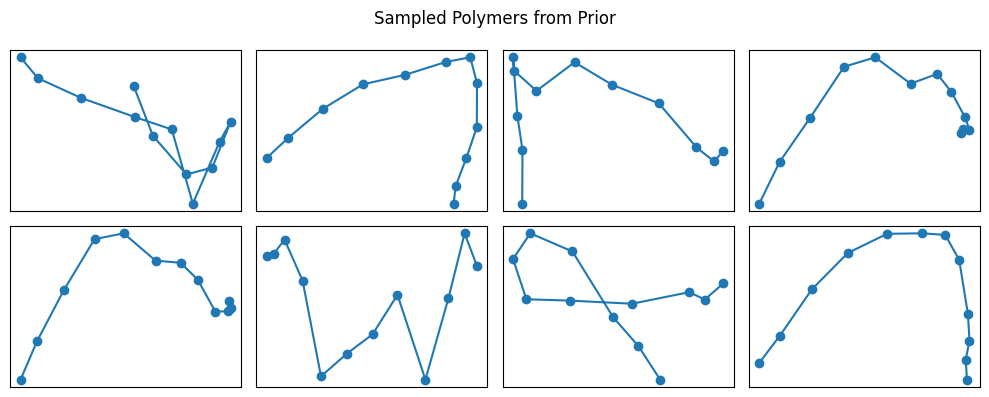

In [127]:
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    x_gen = decoder(z).cpu().numpy().reshape(-1, 12, 2)

# Plot generated samples
plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.plot(x_gen[i, :, 0], x_gen[i, :, 1], 'o-')
    plt.xticks([]); plt.yticks([])
plt.suptitle("Sampled Polymers from Prior")
plt.tight_layout()
plt.show()


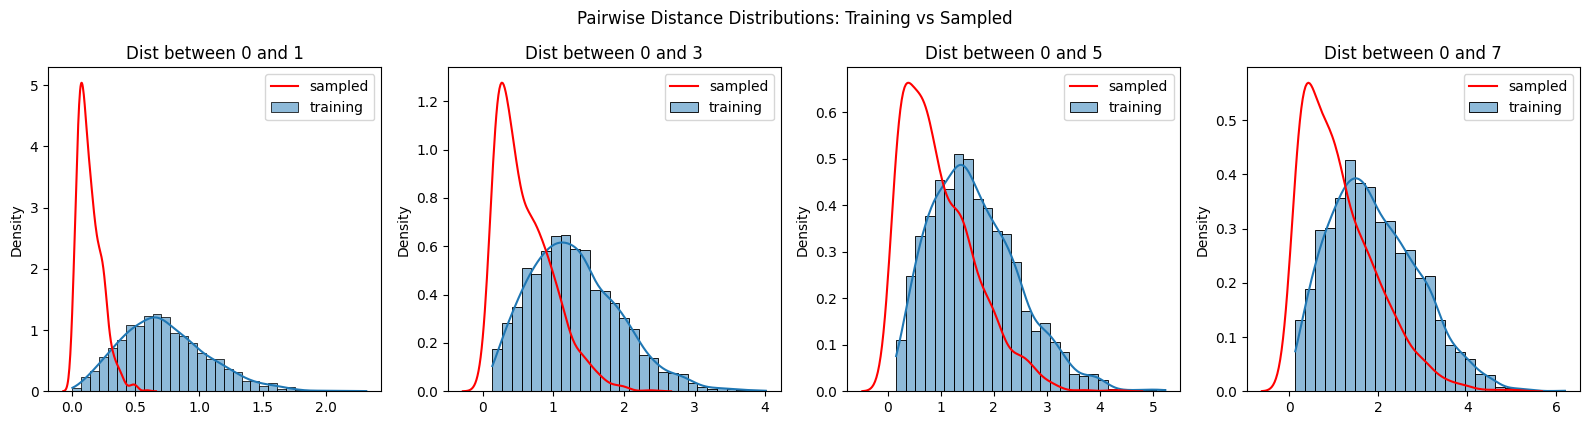

In [128]:
import seaborn as sns

# Step 1: Sample new data from the trained VAE
with torch.no_grad():
    z = torch.randn(1000, latent_dim).to(device)
    x_gen = decoder(z).cpu().numpy().reshape(-1, 12, 2)  # (1000, 12, 2)

# Step 2: Define reference (training) data
x_real = data  # shape (N, 12, 2), aligned + centered original data

# Step 3: Compare distributions of distances from bead 0 to 1, 3, 5, 7
fig, axs = plt.subplots(ncols=4, figsize=(16, 4))

for i, j in enumerate(range(1, 9, 2)):
    axs[i].set_title(f"Dist between 0 and {j}")

    # Real data distances
    d_real = np.linalg.norm(x_real[:, 0] - x_real[:, j], axis=1)

    # Generated data distances
    d_gen = np.linalg.norm(x_gen[:, 0] - x_gen[:, j], axis=1)

    # Plot both
    sns.histplot(d_real, ax=axs[i], kde=True, stat="density", label="training")
    sns.kdeplot(d_gen, ax=axs[i], color="red", label="sampled")

    axs[i].legend()

plt.tight_layout()
plt.suptitle("Pairwise Distance Distributions: Training vs Sampled", y=1.05)
plt.show()


